This notebook does the following for the Xception backbone with DeepLabV3+ and UNET architectures:



*   Train model without any pre-loaded weights
*   Train model using transfer learning with  fine tuning 







IMPORT LIBRARIES AND MOUNT GOOGLE DRIVE
---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os 
import numpy as np 
import keras 
# import re 
import cv2 
import matplotlib.pyplot as plt
import pandas as pd
import sklearn 
from sklearn.model_selection import cross_val_score


import tensorflow as tf 
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception, preprocess_input
from keras.models import Model
from keras import layers
# from bayes_opt import BayesianOptimization as bo


LOAD DATA
---


In [ ]:
os.getcwd()

'/content'

In [ ]:
os.chdir('drive/MyDrive/COMP90055/code/all_data')


In [ ]:
plt.rcParams["figure.figsize"] = (10,10)

In [ ]:
bad_coastal = [4,5,31,39,68,69,74,75,76,89,90,102,121,206,216,217,220,221,248,249,309,310,313,315,316,336,337,361,431,443,488]
weird = [33,35,52,55,276,333,334,335,444]

exclude = [str(num) + ".png" for num in bad_coastal + weird]

In [ ]:
## This is used to display funny images in the dataset which have been removed

# masks = []
# images = []

# for i in weird:

#   name = str(i) + ".png"
#   # print(name)

#   mask = cv2.imread(os.path.join('224_masks_filtered', name), cv2.IMREAD_GRAYSCALE)
#   mask[mask == 2] = 0 ## This removes the cloud mask 
#   masks.append(mask)

#   image = cv2.imread('224_image_filtered/' + name) 
#   image = cv2.imread(os.path.join('224_images_filtered', name))

#   images.append(image)

# masks = np.array(masks)
# images = np.array(images)



# mask = cv2.imread(os.path.join('224_masks_filtered', name), cv2.IMREAD_GRAYSCALE)

# for i in range(len(images)):

#   true_img = images[i]
#   mask = masks[i]



#   fig, (ax, m_ax) = plt.subplots(ncols = 2)


#   ax.imshow(true_img)
#   ax.set_title('Image Patch' + str(weird[i]))
#   ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
#   ax.tick_params(axis = 'y' , left = False, labelleft = False)


#   m_ax.imshow(mask)
#   m_ax.set_title('True Mask')
#   m_ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
#   m_ax.tick_params(axis = 'y' , left = False, labelleft = False)



In [ ]:
# os.chdir('drive/MyDrive/COMP90055/code/all_data')


In [ ]:

## Load masks
mask_directory = '224_masks_filtered'
image_directory = '224_images_filtered'

# mask_filenames = [filename for filename in os.listdir(mask_directory) if filename.endswith(('.png', '.jpeg', '.jpg'))] - exclude
mask_filenames = [filename for filename in os.listdir(mask_directory) if filename.endswith(('.png', '.jpeg', '.jpg')) and filename not in exclude]



filenames = mask_filenames


masks = []

for filename in filenames:

    mask = cv2.imread(os.path.join(mask_directory, filename), cv2.IMREAD_GRAYSCALE)
    # plt.imshow(mask)
    mask[mask == 2] = 0 ## This removes the cloud mask 

    # mask = cv2.resize(mask, (229,229))
    masks.append(mask)

masks_array = np.array(masks)


images = []


for filename in filenames:
  
    image = cv2.imread(os.path.join(image_directory, filename))
    image = cv2.resize(image, (229,229))
    images.append(image)


images_array = np.array(images)
images_array = preprocess_input(images_array)
images_array, masks_array = sklearn.utils.shuffle(images_array, masks_array, random_state = 90055)


print(images_array.shape)
print(masks_array.shape)


(484, 229, 229, 3)
(484, 224, 224)


In [ ]:
train_index = int(images_array.shape[0] * 0.7)
val_index = int(images_array.shape[0] * 0.2)

x_train = images_array[:train_index]
x_val = images_array[train_index:train_index + val_index]
x_test = images_array[train_index + val_index:]

y_train = masks_array[:train_index]
y_val = masks_array[train_index:train_index + val_index]
y_test = masks_array[train_index + val_index:]

final_x_train = images_array[:train_index+val_index]
final_y_train = masks_array[:train_index+val_index]


LOSS FUNCTIONS
---

In [ ]:
from keras.losses import BinaryFocalCrossentropy as BFCE

def dice_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.math.sigmoid(y_pred)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return 1 - numerator / denominator


def dice_focal_loss(y_true, y_pred):
  bin_foc = BFCE()
  return dice_loss(y_true, y_pred) + bin_foc(y_true, y_pred)

MODELS with DEEPLABV3+
---
---


Some functions for constructing the model

Taken from https://keras.io/examples/vision/deeplabv3_plus/ and modified to include dropouts and accomodate transfer and non trasnfer learing

In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
    dropout=0
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    x = tf.nn.relu(x)
    x = layers.Dropout(dropout)(x)

    return x


def DilatedSpatialPyramidPooling(dspp_input, dropout_rate = 0):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True , dropout = dropout_rate)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1, dropout = dropout_rate)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6, dropout = dropout_rate)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12, dropout = dropout_rate)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18, dropout = dropout_rate)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1, dropout = dropout_rate)
    return output

In [ ]:
def DeeplabV3Plus(image_size, num_classes, weights=None, frozen_base=False, dropout_rate = 0 ):
    
    model_input = keras.Input(shape=(image_size, image_size, 3))



    xcept = Xception(
        weights=weights, include_top=False, input_tensor=model_input  
    )

    
    if frozen_base:
      xcept.trainable = False

   
    x = xcept.get_layer("block6_sepconv3_act").output 
    x = DilatedSpatialPyramidPooling(x, dropout_rate = dropout_rate)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)

    input_b = xcept.get_layer("block3_sepconv2_act").output 
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x, dropout = dropout_rate)
    x = convolution_block(x, dropout = dropout_rate)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same", activation='sigmoid')(x)


    return keras.Model(inputs=model_input, outputs=model_output)


Checking our loss functions
---

In [ ]:
tf.keras.backend.clear_session()
model_noweights_dice = DeeplabV3Plus(image_size=229, num_classes=1)
# model_noweights.summary()

model_noweights_dice.compile( optimizer =keras.optimizers.Adam()
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )


history_dice = model_noweights_dice.fit(x = x_train, y = y_train, validation_data = (x_val,y_val), epochs = 100) 



In [ ]:
tf.keras.backend.clear_session()
model_noweights_combo = DeeplabV3Plus(image_size=224, num_classes=1)
# model_noweights.summary()

model_noweights_combo.compile( optimizer =keras.optimizers.Adam()
              ,loss= dice_focal_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )


history_combo = model_noweights_combo.fit(x = x_train, y = y_train, validation_data = (x_val,y_val), epochs = 100) 


In [ ]:
tf.keras.backend.clear_session()
model_noweights_bfce = DeeplabV3Plus(image_size=224, num_classes=1)
# model_noweights.summary()

model_noweights_bfce.compile( optimizer =keras.optimizers.Adam()
              ,loss= BFCE()
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )


history_bfce = model_noweights_bfce.fit(x = x_train, y = y_train, validation_data = (x_val,y_val), epochs = 100) 


NO PRE LOADED WEIGHTS
---

Hyper Parameter Tuning

In [ ]:
from bayes_opt import BayesianOptimization

# Import the required loss functions

# Define the objective function
def objective(learning_rate, dropout_rate):
    # Build the model with the current hyperparameters
    tf.keras.backend.clear_session()

    model = DeeplabV3Plus(229, 1, dropout_rate=dropout_rate)

   

    datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate = learning_rate), loss=dice_loss,
                  metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

    history = model.fit(datagen.flow(x_train, y_train, batch_size=16),
                        validation_data=(x_val, y_val), epochs=100, verbose=0)

    p = history.history['val_precision'][-1]
    r = history.history['val_recall'][-1]

    f1 = 2*(p*r)/(p+r)

    # Return the validation accuracy as the objective value to maximize
    return f1

# Define the parameter space
pbounds = {'learning_rate': (1e-5, 1e-2),
           'dropout_rate': (0, 0.5)
           }

# Create the optimizer
optimizer = BayesianOptimization(f=objective, pbounds=pbounds)

# Perform the optimization
optimizer.maximize(init_points=5, n_iter=10)

# Get the best set of hyperparameters
best_params = optimizer.max['params']
print(best_params)


# best_learning_rate = best_params['learning_rate']
# best_dropout_rate = best_params['dropout_rate']# best_loss_function = best_params['loss_function']


|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
| 1         | 0.01523   | 0.3406    | 0.00412   |
| 2         | 0.03235   | 0.2776    | 0.001631  |
| 3         | 0.1208    | 0.1652    | 0.004332  |
| 4         | 0.04991   | 0.428     | 0.004805  |
| 5         | 0.03066   | 0.4627    | 0.003396  |
| 6         | 0.03387   | 0.4281    | 0.004932  |
| 7         | 0.02881   | 0.1729    | 0.00788   |
| 8         | 0.02179   | 0.2387    | 0.002871  |
| 9         | 0.01386   | 0.165     | 0.004693  |
| 10        | 0.03215   | 0.1651    | 0.00444   |
| 11        | 0.04137   | 0.4282    | 0.004846  |
| 12        | 0.03095   | 0.1654    | 0.004349  |
| 13        | 0.0242    | 0.4631    | 0.004096  |
| 14        | 0.03194   | 0.07975   | 0.005873  |
| 15        | 0.06643   | 0.1325    | 0.0008898 |
{'dropout_rate': 0.16521626724362348, 'learning_rate': 0.004332010887775081}


In [ ]:
tf.keras.backend.clear_session()

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tuned_model = DeeplabV3Plus(229,1, dropout_rate = 0.16521626724362348)
tuned_model.compile( optimizer =keras.optimizers.Adam(0.004332010887775081)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )

tuned_history = tuned_model.fit(datagen.flow(x_train, y_train, batch_size=16),
                      validation_data=(x_val, y_val), epochs=500)

tuned_model.save("xceptionDLV3_NPW_tuned_500e_bs16.h5")

np.save('history_xceptionDLV3_NPW_tuned_500e_bs16.npy',tuned_history.history)



Epoch 1/500
22/22 [==============================] - 20s 289ms/step - loss: 0.9793 - accuracy: 0.4990 - recall: 0.5069 - precision: 0.0106 - val_loss: 0.9792 - val_accuracy: 0.6335 - val_recall: 0.3552 - val_precision: 0.0104
Epoch 2/500
22/22 [==============================] - 3s 119ms/step - loss: 0.9785 - accuracy: 0.6411 - recall: 0.4734 - precision: 0.0139 - val_loss: 0.9786 - val_accuracy: 0.2601 - val_recall: 0.8136 - val_precision: 0.0116
Epoch 3/500
22/22 [==============================] - 3s 120ms/step - loss: 0.9785 - accuracy: 0.6948 - recall: 0.4214 - precision: 0.0146 - val_loss: 0.9792 - val_accuracy: 0.9880 - val_recall: 0.0021 - val_precision: 0.0163
Epoch 4/500
22/22 [==============================] - 3s 119ms/step - loss: 0.9779 - accuracy: 0.6398 - recall: 0.5482 - precision: 0.0159 - val_loss: 0.9799 - val_accuracy: 0.5140 - val_recall: 0.3824 - val_precision: 0.0084
Epoch 5/500
22/22 [==============================] - 3s 119ms/step - loss: 0.9784 - accuracy: 0.592

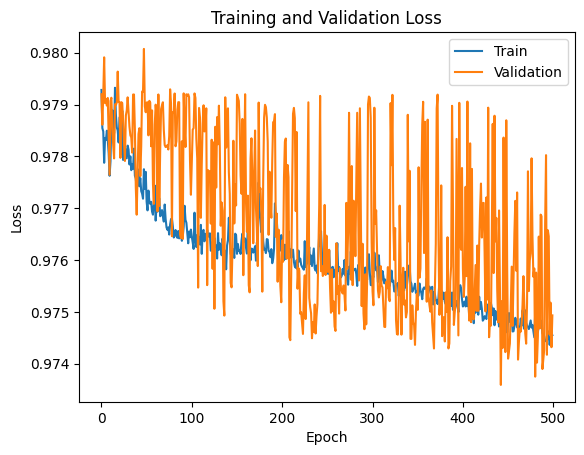

In [ ]:
## Assess at which point the model becomes overfit 

xDL_NW_hist = np.load("history_xceptionDLV3_NPW_tuned_500e_bs16.npy", allow_pickle = True).item()

xDL_NW_hist['loss']


plt.plot(xDL_NW_hist['loss'], label='Train')
plt.plot(xDL_NW_hist['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Difficult to tell. Default to 100 epochs. Huge fluctuations

In [ ]:
tf.keras.backend.clear_session()

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tuned_model = DeeplabV3Plus(229,1, dropout_rate = 0.16521626724362348)
tuned_model.compile( optimizer =keras.optimizers.Adam(0.004332010887775081)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )

tuned_history = tuned_model.fit(datagen.flow(final_x_train, final_y_train, batch_size=16), epochs=100)



Epoch 1/100
28/28 [==============================] - 18s 133ms/step - loss: 0.9784 - accuracy: 0.6343 - recall: 0.4763 - precision: 0.0137
Epoch 2/100
28/28 [==============================] - 3s 109ms/step - loss: 0.9784 - accuracy: 0.4907 - recall: 0.6289 - precision: 0.0129
Epoch 3/100
28/28 [==============================] - 3s 108ms/step - loss: 0.9782 - accuracy: 0.5195 - recall: 0.6268 - precision: 0.0137
Epoch 4/100
28/28 [==============================] - 3s 108ms/step - loss: 0.9782 - accuracy: 0.5707 - recall: 0.5788 - precision: 0.0142
Epoch 5/100
28/28 [==============================] - 3s 108ms/step - loss: 0.9784 - accuracy: 0.4967 - recall: 0.6159 - precision: 0.0128
Epoch 6/100
28/28 [==============================] - 3s 109ms/step - loss: 0.9786 - accuracy: 0.3997 - recall: 0.6988 - precision: 0.0122
Epoch 7/100
28/28 [==============================] - 3s 108ms/step - loss: 0.9780 - accuracy: 0.6258 - recall: 0.5350 - precision: 0.0150
Epoch 8/100
28/28 [==============

2/2 [==============================] - 4s 1s/step


Accuracy  0.06929408482142857
Precison  0.9858176676093828
Recall  0.010050811659331634
IoU 0.010049358575935977


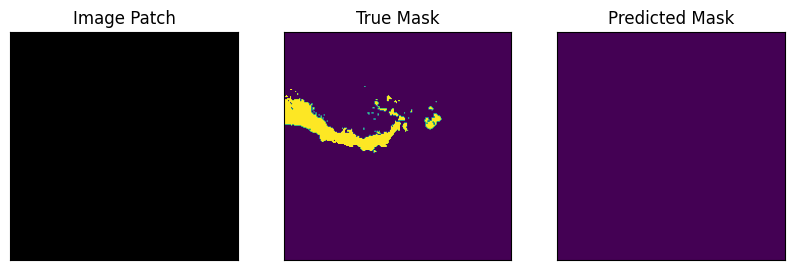

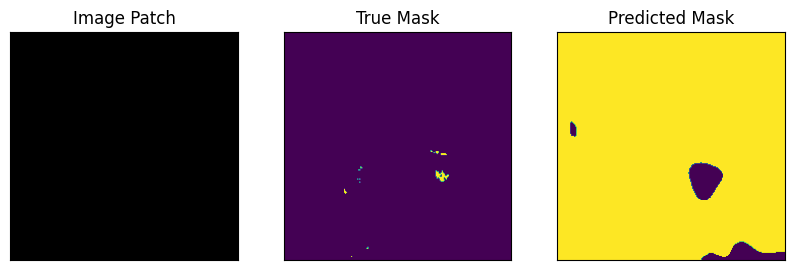

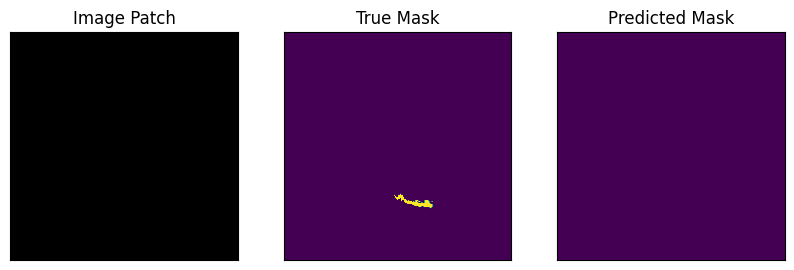

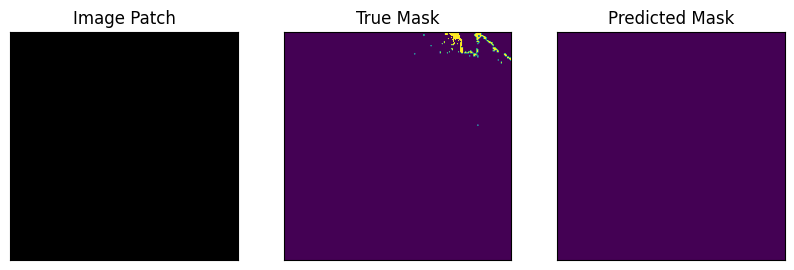

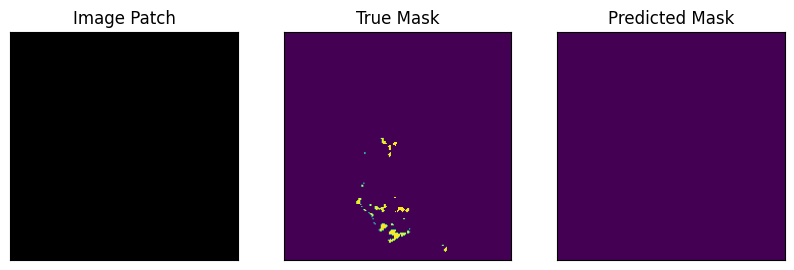

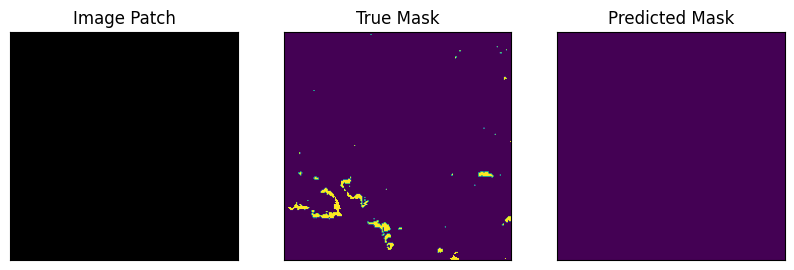

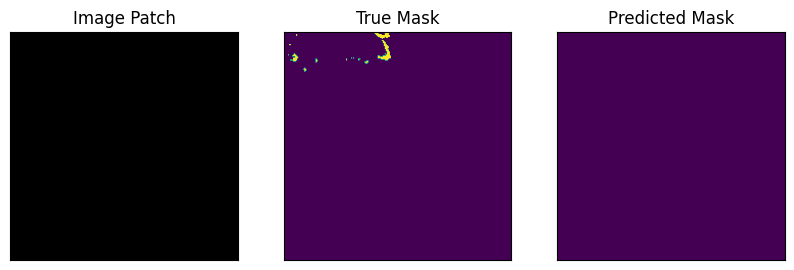

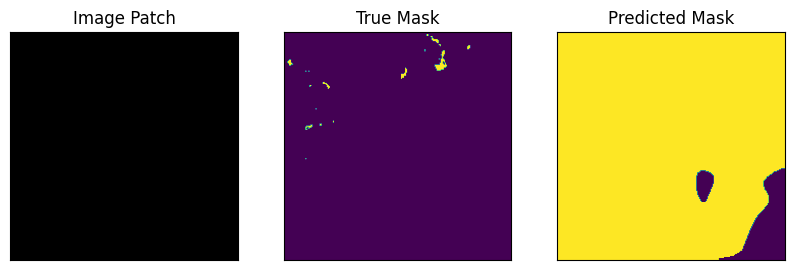

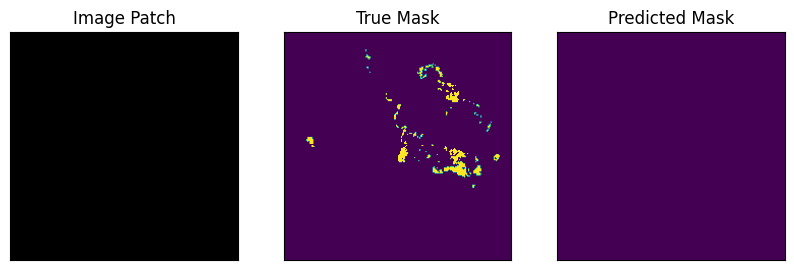

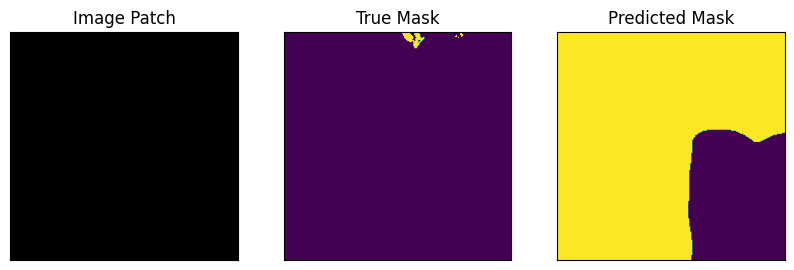

In [ ]:
preds = tuned_model.predict(x_test)

from sklearn import metrics


accuracy = metrics.accuracy_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))
precision = metrics.precision_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))
recall = metrics.recall_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))
IoU = metrics.jaccard_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))

print("Accuracy ", accuracy)
print("Precison ", precision)
print("Recall ", recall)
print("IoU", IoU)

for i in range(len(x_test[0:10])):

  true_img = x_test[i]
  mask = y_test[i]
  prediction_image = np.rint(preds[i])

  fig, (ax, m_ax, p_ax) = plt.subplots(ncols = 3)
  ax.imshow(true_img*3.5/255)
  ax.set_title('Image Patch')
  ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  ax.tick_params(axis = 'y' , left = False, labelleft = False)


  m_ax.imshow(mask)
  m_ax.set_title('True Mask')
  m_ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  m_ax.tick_params(axis = 'y' , left = False, labelleft = False)

  p_ax.imshow(prediction_image)
  p_ax.set_title('Predicted Mask')
  p_ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  p_ax.tick_params(axis = 'y' , left = False, labelleft = False)


TRANSFER LEARNING FINE TUNING
---

In [ ]:
model_transfer = DeeplabV3Plus(image_size=224, num_classes=1, weights = 'imagenet', frozen_base = True)
model_transfer.summary()

In [ ]:
from bayes_opt import BayesianOptimization

# Import the required loss functions

# Define the objective function
def objective(learning_rate, dropout_rate):
    # Build the model with the current hyperparameters
    tf.keras.backend.clear_session()

    model = DeeplabV3Plus(229, 1, dropout_rate=dropout_rate, weights = 'imagenet', frozen_base = True)   

    datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate = learning_rate), loss=dice_loss,
                  metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

    history = model.fit(datagen.flow(x_train, y_train, batch_size=16),
                        validation_data=(x_val, y_val), epochs=100, verbose=0)

    p = history.history['val_precision'][-1]
    r = history.history['val_recall'][-1]

    f1 = 2*(p*r)/(p+r)

    # Return the validation accuracy as the objective value to maximize
    return f1

# Define the parameter space
pbounds = {'learning_rate': (1e-5, 1e-2),
           'dropout_rate': (0, 0.5)
           }

# Create the optimizer
optimizer = BayesianOptimization(f=objective, pbounds=pbounds)

# Perform the optimization
optimizer.maximize(init_points=5, n_iter=10)

# Get the best set of hyperparameters
best_params = optimizer.max['params']
print(best_params)


# best_learning_rate = best_params['learning_rate']
# best_dropout_rate = best_params['dropout_rate']
# best_loss_function = best_params['loss_function']

|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
83683744/83683744 [==============================] - 3s 0us/step
| 1         | 0.0731    | 0.1463    | 0.003999  |
| 2         | 0.1343    | 0.3355    | 0.0004395 |
| 3         | 0.08359   | 0.149     | 0.008503  |
| 4         | 0.06662   | 0.1768    | 0.003378  |
| 5         | 0.05994   | 0.05111   | 0.009107  |
| 6         | 0.07282   | 0.349     | 0.0006262 |
| 7         | 0.1261    | 0.3308    | 0.000375  |
| 8         | 0.08563   | 0.191     | 0.001558  |
| 9         | 0.1023    | 0.3082    | 0.004761  |
| 10        | 0.1125    | 0.3344    | 0.007923  |
| 11        | 0.0841    | 0.3214    | 0.009861  |
| 12        | 0.1091    | 0.3649    | 0.00777   |
| 13        | 0.1129    | 0.3359    | 0.0001606 |
| 14        | 0.08176   | 0.3342    | 0.007639  |
| 15        | 0.1121    | 0.1365    | 0.008848  |
{'dropout_rate': 0.33548658083839206, 'learning_rate': 0.0004395295582474708}


In [ ]:
tf.keras.backend.clear_session()

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tuned_model = DeeplabV3Plus(229, 1, dropout_rate=0.33548658083839206, weights = 'imagenet', frozen_base = True)   
tuned_model.compile( optimizer =keras.optimizers.Adam(0.0004395295582474708)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )

tuned_history = tuned_model.fit(datagen.flow(x_train, y_train, batch_size=16),
                      validation_data=(x_val, y_val), epochs=500)

tuned_model.save("xceptionDLV3_TL_tuned_500e_bs16.h5")

np.save('history_xceptionDLV3_TL_tuned_500e_bs16.npy',tuned_history.history)



83683744/83683744 [==============================] - 3s 0us/step
Epoch 1/500
22/22 [==============================] - 5s 105ms/step - loss: 0.9783 - accuracy: 0.5253 - recall: 0.6262 - precision: 0.0138 - val_loss: 0.9764 - val_accuracy: 0.8131 - val_recall: 0.5900 - val_precision: 0.0333
Epoch 2/500
22/22 [==============================] - 2s 69ms/step - loss: 0.9774 - accuracy: 0.6413 - recall: 0.6188 - precision: 0.0180 - val_loss: 0.9759 - val_accuracy: 0.7682 - val_recall: 0.7096 - val_precision: 0.0320
Epoch 3/500
22/22 [==============================] - 2s 69ms/step - loss: 0.9767 - accuracy: 0.6929 - recall: 0.6447 - precision: 0.0218 - val_loss: 0.9759 - val_accuracy: 0.8368 - val_recall: 0.6607 - val_precision: 0.0422
Epoch 4/500
22/22 [==============================] - 1s 67ms/step - loss: 0.9766 - accuracy: 0.7131 - recall: 0.6312 - precision: 0.0229 - val_loss: 0.9759 - val_accuracy: 0.8872 - val_recall: 0.5569 - val_precision: 0.0520
Epoch 5/500
22/22 [===================

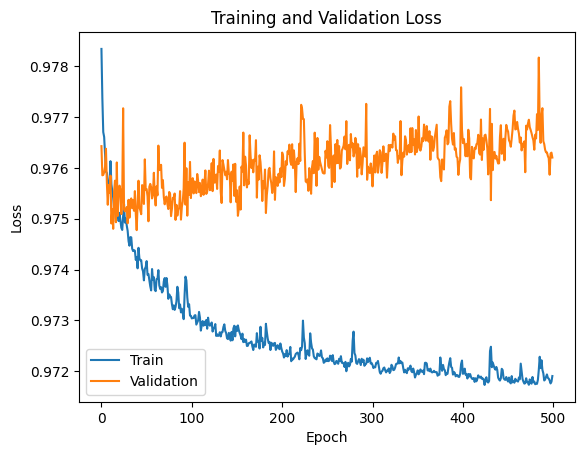

In [ ]:
## Assess at which point the model becomes overfit 

xDL_TL_hist = np.load("history_xceptionDLV3_TL_tuned_500e_bs16.npy", allow_pickle = True).item()

# xDL_NW_hist['loss']


plt.plot(xDL_TL_hist['loss'], label='Train')
plt.plot(xDL_TL_hist['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Looks like we begin to become overfit around 30 epochs. 

In [ ]:

tf.keras.backend.clear_session()

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tuned_model = DeeplabV3Plus(229, 1, dropout_rate=0.33548658083839206, weights = 'imagenet', frozen_base = True)   
tuned_model.compile( optimizer =keras.optimizers.Adam(0.0004395295582474708)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )

tuned_history = tuned_model.fit(datagen.flow(x_train, y_train, batch_size=16),
                      validation_data=(x_val, y_val), epochs=30)

Epoch 1/30
22/22 [==============================] - 8s 231ms/step - loss: 0.9784 - accuracy: 0.5375 - recall: 0.6169 - precision: 0.0139 - val_loss: 0.9770 - val_accuracy: 0.8096 - val_recall: 0.5106 - val_precision: 0.0285
Epoch 2/30
22/22 [==============================] - 4s 201ms/step - loss: 0.9770 - accuracy: 0.6351 - recall: 0.6670 - precision: 0.0190 - val_loss: 0.9764 - val_accuracy: 0.6642 - val_recall: 0.7919 - val_precision: 0.0246
Epoch 3/30
22/22 [==============================] - 4s 201ms/step - loss: 0.9764 - accuracy: 0.7262 - recall: 0.6386 - precision: 0.0243 - val_loss: 0.9765 - val_accuracy: 0.5392 - val_recall: 0.9093 - val_precision: 0.0206
Epoch 4/30
22/22 [==============================] - 4s 202ms/step - loss: 0.9765 - accuracy: 0.7387 - recall: 0.6117 - precision: 0.0244 - val_loss: 0.9763 - val_accuracy: 0.5483 - val_recall: 0.8840 - val_precision: 0.0205
Epoch 5/30
22/22 [==============================] - 4s 202ms/step - loss: 0.9762 - accuracy: 0.7632 - re

In [ ]:
tuned_model.trainable = True


In [ ]:
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tuned_model.compile( optimizer =keras.optimizers.Adam(0.00001)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )

tuned_history = tuned_model.fit(datagen.flow(x_train, y_train, batch_size=16),
                      validation_data=(x_val, y_val), epochs=120)

Epoch 1/120
22/22 [==============================] - 11s 377ms/step - loss: 0.9766 - accuracy: 0.8535 - recall_1: 0.4593 - precision_1: 0.0332 - val_loss: 0.9751 - val_accuracy: 0.7702 - val_recall_1: 0.7073 - val_precision_1: 0.0321
Epoch 2/120
22/22 [==============================] - 8s 343ms/step - loss: 0.9765 - accuracy: 0.8529 - recall_1: 0.4795 - precision_1: 0.0344 - val_loss: 0.9751 - val_accuracy: 0.7579 - val_recall_1: 0.7271 - val_precision_1: 0.0313
Epoch 3/120
22/22 [==============================] - 8s 345ms/step - loss: 0.9763 - accuracy: 0.8524 - recall_1: 0.5050 - precision_1: 0.0359 - val_loss: 0.9750 - val_accuracy: 0.7479 - val_recall_1: 0.7446 - val_precision_1: 0.0308
Epoch 4/120
22/22 [==============================] - 8s 346ms/step - loss: 0.9759 - accuracy: 0.8536 - recall_1: 0.5453 - precision_1: 0.0389 - val_loss: 0.9750 - val_accuracy: 0.7456 - val_recall_1: 0.7470 - val_precision_1: 0.0306
Epoch 5/120
22/22 [==============================] - 8s 346ms/step 

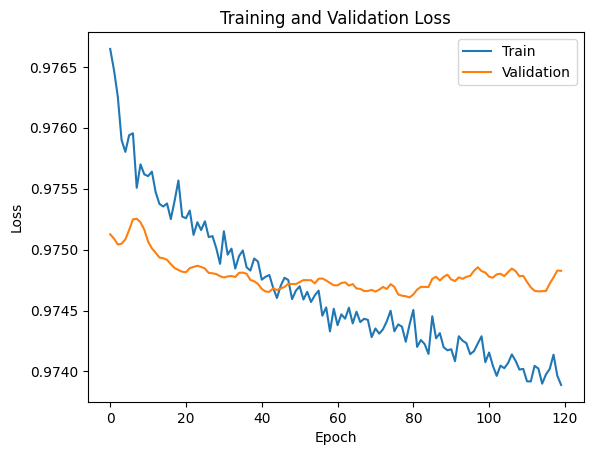

In [ ]:
plt.plot(tuned_history.history['loss'], label='Train')
plt.plot(tuned_history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

We see that after about 45 epochs we begin to overfit. Therefore train for 30, unfreeze, then train for 45.

In [ ]:
tf.keras.backend.clear_session()

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tuned_model = DeeplabV3Plus(229, 1, dropout_rate=0.33548658083839206, weights = 'imagenet', frozen_base = True)   
tuned_model.compile( optimizer =keras.optimizers.Adam(0.0004395295582474708)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )
tuned_model.fit(datagen.flow(final_x_train, final_y_train, batch_size=16), epochs=30)

tuned_model.trainable = True

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tuned_model.compile( optimizer =keras.optimizers.Adam(0.00001)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )

tuned_history = tuned_model.fit(datagen.flow(final_x_train, final_y_train, batch_size=16), epochs=45)

Epoch 1/30
28/28 [==============================] - 4s 58ms/step - loss: 0.9780 - accuracy: 0.5181 - recall: 0.6629 - precision: 0.0144
Epoch 2/30
28/28 [==============================] - 2s 57ms/step - loss: 0.9771 - accuracy: 0.6347 - recall: 0.6401 - precision: 0.0183
Epoch 3/30
28/28 [==============================] - 2s 57ms/step - loss: 0.9769 - accuracy: 0.7106 - recall: 0.5918 - precision: 0.0214
Epoch 4/30
28/28 [==============================] - 2s 57ms/step - loss: 0.9763 - accuracy: 0.7344 - recall: 0.6320 - precision: 0.0248
Epoch 5/30
28/28 [==============================] - 2s 57ms/step - loss: 0.9763 - accuracy: 0.7307 - recall: 0.6352 - precision: 0.0246
Epoch 6/30
28/28 [==============================] - 2s 58ms/step - loss: 0.9760 - accuracy: 0.7643 - recall: 0.6408 - precision: 0.0283
Epoch 7/30
28/28 [==============================] - 2s 57ms/step - loss: 0.9761 - accuracy: 0.7750 - recall: 0.6053 - precision: 0.0281
Epoch 8/30
28/28 [==============================

In [ ]:
tuned_model.save("xceptionDL_TL_best.h5")

np.save('history_xceptionDL_TL_best.npy',tuned_history.history)

2/2 [==============================] - 1s 63ms/step


Accuracy  0.8705301339285715
Precison  0.6183247379803694
Recall  0.04498281412630407
IoU 0.04376753483415322
F1 0.08386452610083824


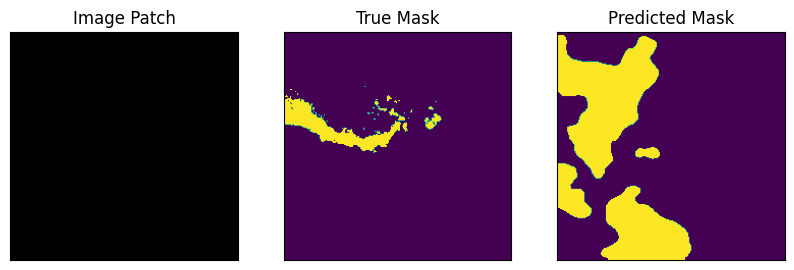

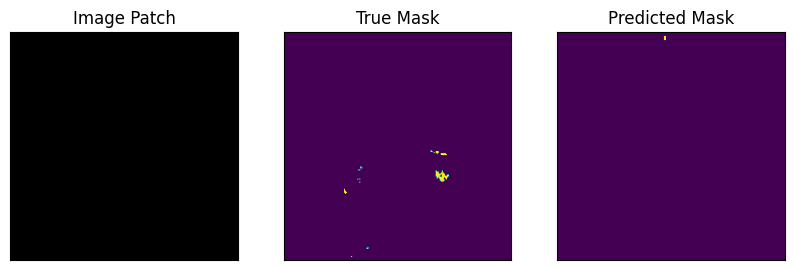

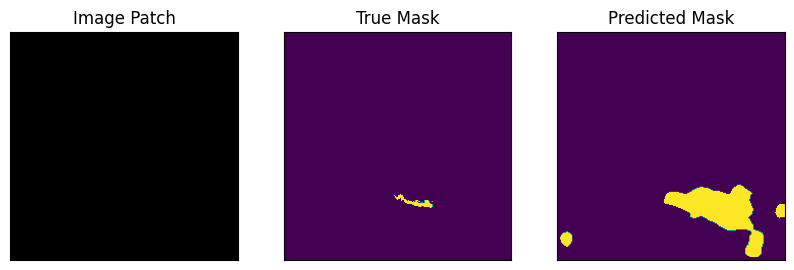

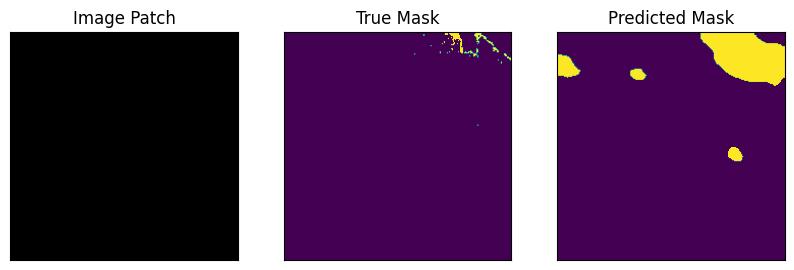

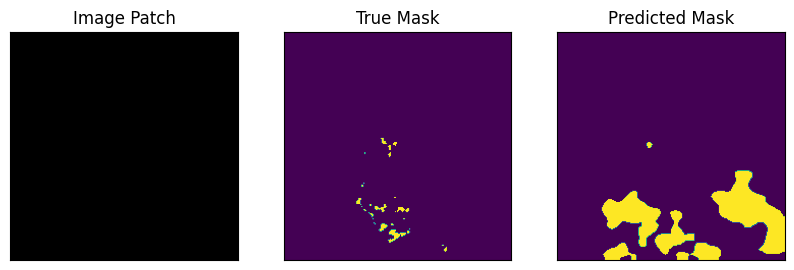

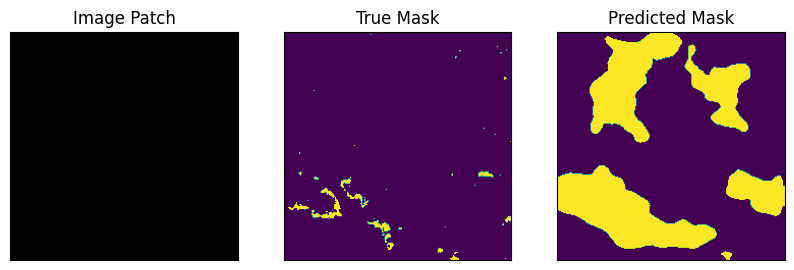

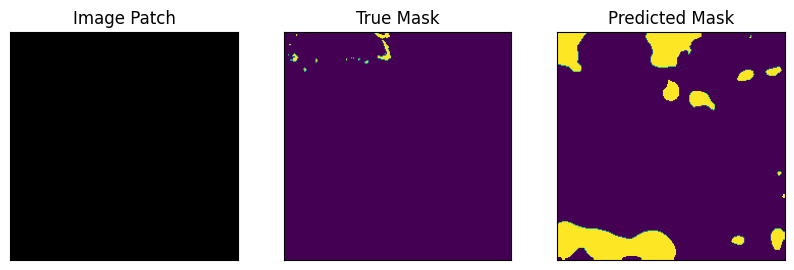

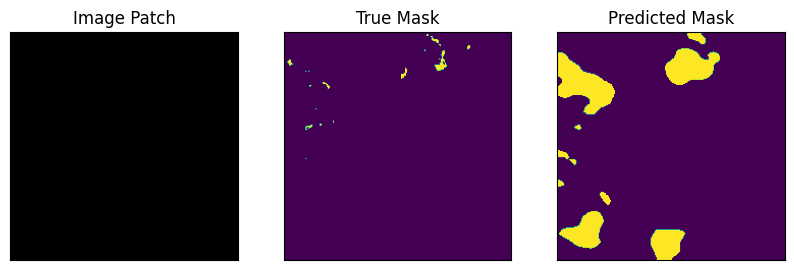

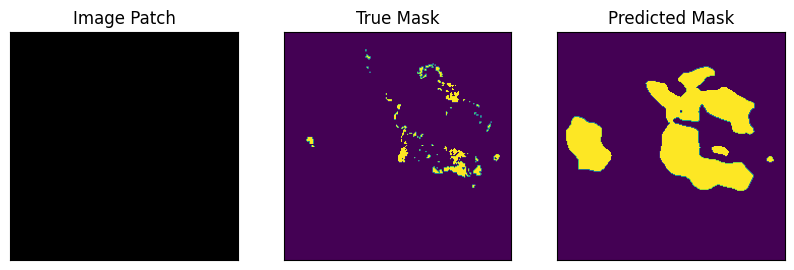

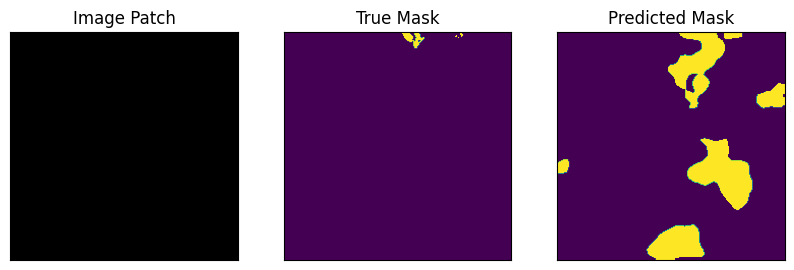

In [ ]:
preds = tuned_model.predict(x_test)

from sklearn import metrics


accuracy = metrics.accuracy_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))
precision = metrics.precision_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))
recall = metrics.recall_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))
IoU = metrics.jaccard_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))

print("Accuracy ", accuracy)
print("Precison ", precision)
print("Recall ", recall)
print("IoU", IoU)
print("F1", 2*(precision*recall)/(precision+recall))

for i in range(len(x_test[0:10])):

  true_img = x_test[i]
  mask = y_test[i]
  prediction_image = np.rint(preds[i])

  fig, (ax, m_ax, p_ax) = plt.subplots(ncols = 3)
  ax.imshow(true_img*3.5/255)
  ax.set_title('Image Patch')
  ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  ax.tick_params(axis = 'y' , left = False, labelleft = False)


  m_ax.imshow(mask)
  m_ax.set_title('True Mask')
  m_ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  m_ax.tick_params(axis = 'y' , left = False, labelleft = False)

  p_ax.imshow(prediction_image)
  p_ax.set_title('Predicted Mask')
  p_ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  p_ax.tick_params(axis = 'y' , left = False, labelleft = False)

UNET
---
---

Adapted and modified from https://github.com/nikhilroxtomar/Semantic-Segmentation-Architecture

In [ ]:


from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Cropping2D
from keras.models import Model
from keras.applications import ResNet50



def conv_block(input, num_filters, dropout_rate = 0):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = layers.Dropout(dropout_rate)(x)

    return x

def decoder_block(input, skip_features, num_filters, dropout_rate = 0):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters, dropout_rate = dropout_rate)
    return x

def build_xception_unet(input_shape, weights = None, frozen_base = False ,dropout_rate = 0):

    inputs = Input(input_shape)

    xcept = Xception(include_top=False, weights = weights, input_tensor=inputs)

    if frozen_base:
      xcept.trainable = False

    s1 = xcept.get_layer("input_1").output              
    s2 = xcept.get_layer("block2_sepconv2_act").output  
    s3 = xcept.get_layer("block3_sepconv2_act").output   
    s4 = xcept.get_layer("block4_sepconv2_act").output  

   
    b1 = xcept.get_layer("block13_sepconv2_act").output  

   
    d1 = decoder_block(b1, s4, 512, dropout_rate = dropout_rate)                     
    d2 = decoder_block(d1, s3, 256, dropout_rate = dropout_rate)                   
    d3 = decoder_block(d2, s2, 128, dropout_rate = dropout_rate)                    
    crop_s1 = Cropping2D(cropping=((3, 2), (3, 2)))(s1) ## Need to crop to concatenate
    d4 = decoder_block(d3, crop_s1, 64, dropout_rate = dropout_rate)                  


    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="Xception_U-Net")
    return model


NO PRELOADED WEIGHTS
---

In [ ]:
tf.keras.backend.clear_session()
model = build_xception_unet((229,229,3))

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

model.compile(optimizer=keras.optimizers.Adam(), loss=dice_loss,
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

history = model.fit(datagen.flow(x_train, y_train, batch_size=16),
                    validation_data=(x_val, y_val), epochs=10)


In [ ]:
from bayes_opt import BayesianOptimization

# Import the required loss functions

# Define the objective function
def objective(learning_rate, dropout_rate):
    # Build the model with the current hyperparameters
    tf.keras.backend.clear_session()

    model = build_xception_unet((229,229,3), dropout_rate = dropout_rate)


    datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate = learning_rate), loss=dice_loss,
                  metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

    history = model.fit(datagen.flow(x_train, y_train, batch_size=16),
                        validation_data=(x_val, y_val), epochs=100, verbose=0)

    p = history.history['val_precision'][-1]
    r = history.history['val_recall'][-1]

    f1 = 2*(p*r)/(p+r)

    # Return the validation accuracy as the objective value to maximize
    return f1

# Define the parameter space
pbounds = {'learning_rate': (1e-5, 1e-2),
           'dropout_rate': (0, 0.5)
           }

# Create the optimizer
optimizer = BayesianOptimization(f=objective, pbounds=pbounds)

# Perform the optimization
optimizer.maximize(init_points=5, n_iter=10)

# Get the best set of hyperparameters
best_params = optimizer.max['params']
print(best_params)


# best_learning_rate = best_params['learning_rate']
# best_dropout_rate = best_params['dropout_rate']
# best_loss_function = best_params['loss_function']

|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
| 1         | 0.1284    | 0.1282    | 0.001458  |
| 2         | 0.02112   | 0.1386    | 0.005401  |
| 3         | 0.03616   | 0.446     | 0.0009421 |
| 4         | 0.01657   | 0.3823    | 0.006055  |
| 5         | 0.03909   | 0.06524   | 0.008735  |
| 6         | 0.02125   | 0.1036    | 0.008794  |
| 7         | 0.06833   | 0.1282    | 0.001595  |
| 8         | 0.08473   | 0.01536   | 0.002489  |
| 9         | 0.03142   | 0.3148    | 0.007134  |
| 10        | 0.04372   | 0.1285    | 0.001734  |
| 11        | 0.03718   | 0.01554   | 0.002627  |
| 12        | 0.05024   | 0.4716    | 0.001346  |
| 13        | 0.03396   | 0.4719    | 0.001171  |
| 14        | 0.02228   | 0.3301    | 0.004134  |
| 15        | 0.04169   | 0.1282    | 0.001614  |
{'dropout_rate': 0.12823131275997335, 'learning_rate': 0.001458256893239116}


In [ ]:
tf.keras.backend.clear_session()

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tuned_model = build_xception_unet((229,229,3), dropout_rate = 0.12823131275997335)
tuned_model.compile( optimizer =keras.optimizers.Adam(0.001458256893239116)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )

tuned_history = tuned_model.fit(datagen.flow(x_train, y_train, batch_size=16),
                      validation_data=(x_val, y_val), epochs=500)

tuned_model.save("xceptionUNET_NW_tuned_500e_bs16.h5")

np.save('history_xceptionUNET_NW_tuned_500e_bs16.npy',tuned_history.history)


Epoch 1/500
22/22 [==============================] - 12s 307ms/step - loss: 0.9785 - accuracy: 0.6348 - recall: 0.4807 - precision: 0.0138 - val_loss: 0.9791 - val_accuracy: 0.9893 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/500
22/22 [==============================] - 5s 249ms/step - loss: 0.9780 - accuracy: 0.7672 - recall: 0.4162 - precision: 0.0189 - val_loss: 0.9792 - val_accuracy: 0.9894 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/500
22/22 [==============================] - 5s 237ms/step - loss: 0.9779 - accuracy: 0.7011 - recall: 0.4888 - precision: 0.0172 - val_loss: 0.9792 - val_accuracy: 0.9894 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/500
22/22 [==============================] - 5s 237ms/step - loss: 0.9782 - accuracy: 0.7331 - recall: 0.4166 - precision: 0.0165 - val_loss: 0.9792 - val_accuracy: 0.9894 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/500
22/22 [==============================] - 5s 238ms/step 

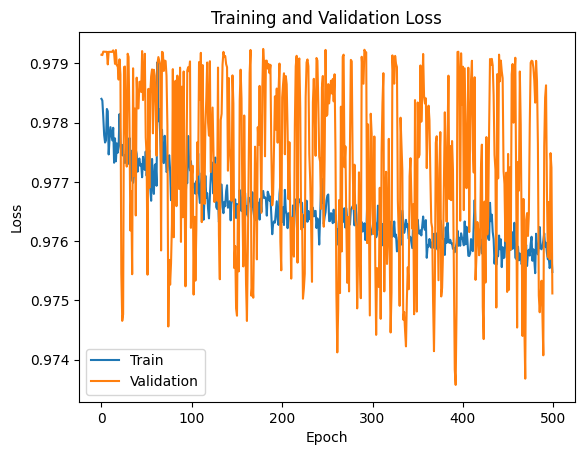

In [ ]:
## Assess at which point the model becomes overfit 

xUNET_NW_hist = np.load("history_xceptionUNET_NW_tuned_500e_bs16.npy", allow_pickle = True).item()

# xDL_NW_hist['loss']


plt.plot(xUNET_NW_hist['loss'], label='Train')
plt.plot(xUNET_NW_hist['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Difficult to tell. Trainin set to 100 epochs. 

In [ ]:


tf.keras.backend.clear_session()

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tuned_model_UNW = build_xception_unet((229,229,3), dropout_rate = 0.12823131275997335)
tuned_model_UNW.compile( optimizer =keras.optimizers.Adam(0.001458256893239116)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )

tuned_history_UNW = tuned_model_UNW.fit(datagen.flow(final_x_train, final_y_train, batch_size=16), epochs=100)


Epoch 1/100
28/28 [==============================] - 25s 274ms/step - loss: 0.9786 - accuracy: 0.7103 - recall: 0.3962 - precision: 0.0145
Epoch 2/100
28/28 [==============================] - 6s 223ms/step - loss: 0.9777 - accuracy: 0.6705 - recall: 0.5316 - precision: 0.0170
Epoch 3/100
28/28 [==============================] - 6s 223ms/step - loss: 0.9778 - accuracy: 0.6475 - recall: 0.5366 - precision: 0.0160
Epoch 4/100
28/28 [==============================] - 6s 223ms/step - loss: 0.9782 - accuracy: 0.7134 - recall: 0.4320 - precision: 0.0160
Epoch 5/100
28/28 [==============================] - 6s 223ms/step - loss: 0.9780 - accuracy: 0.7033 - recall: 0.4626 - precision: 0.0165
Epoch 6/100
28/28 [==============================] - 6s 222ms/step - loss: 0.9778 - accuracy: 0.7262 - recall: 0.4496 - precision: 0.0174
Epoch 7/100
28/28 [==============================] - 6s 223ms/step - loss: 0.9776 - accuracy: 0.7538 - recall: 0.4558 - precision: 0.0196
Epoch 8/100
28/28 [==============

2/2 [==============================] - 0s 109ms/step


Accuracy  0.9878535554846939
Precison  0.0004990850108135085
Recall  0.0018596001859600185
IoU 0.00039363621453173694


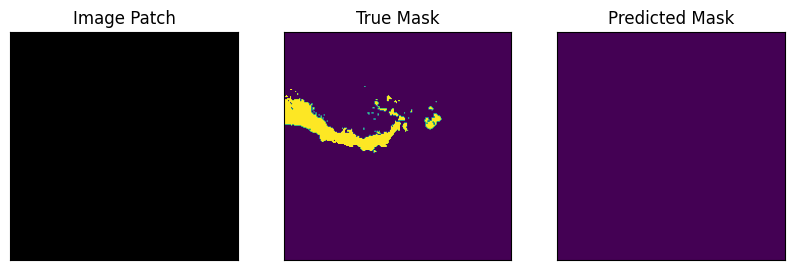

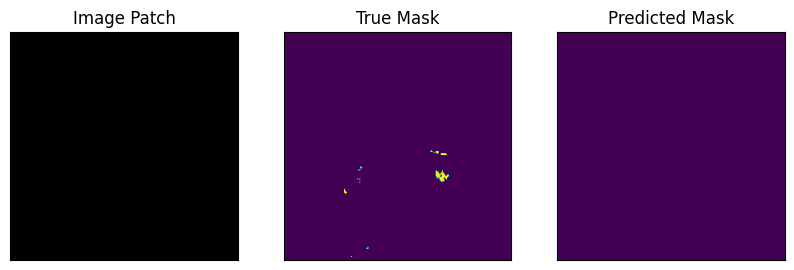

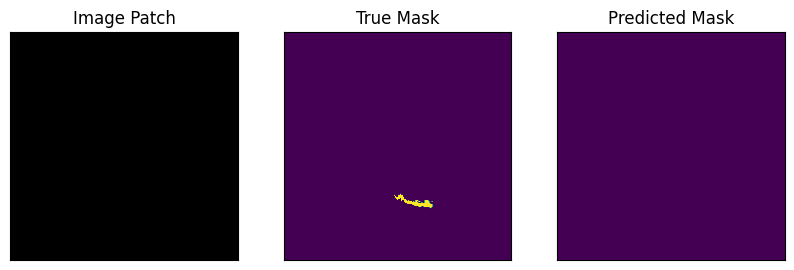

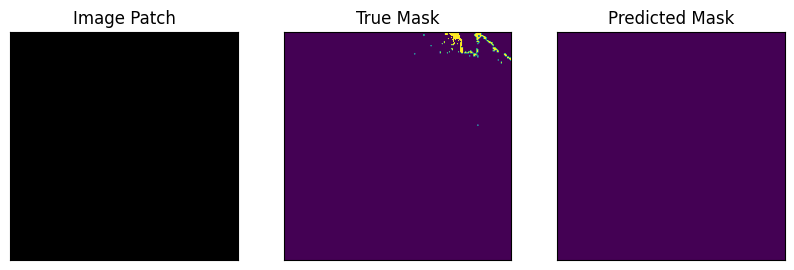

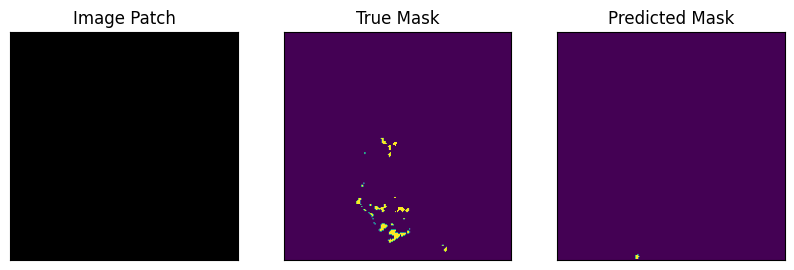

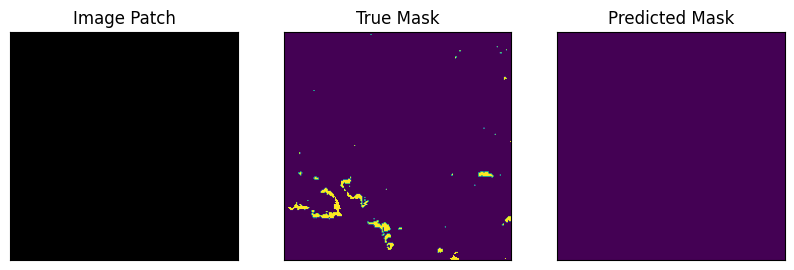

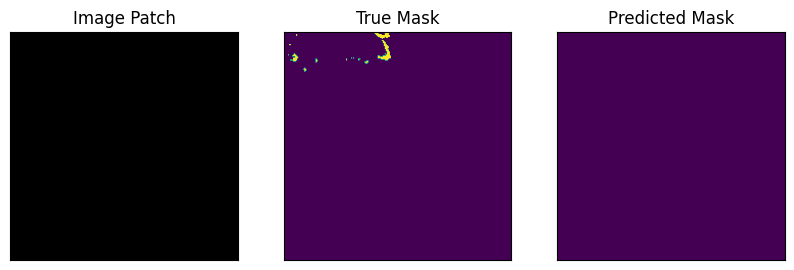

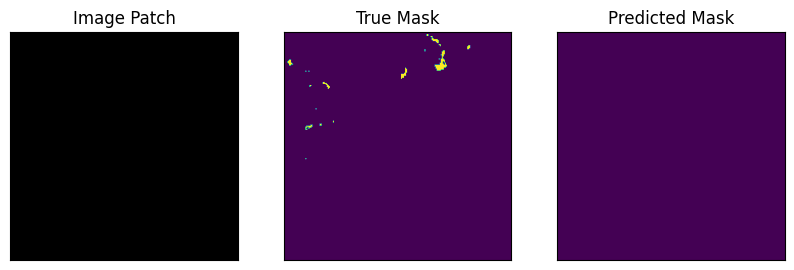

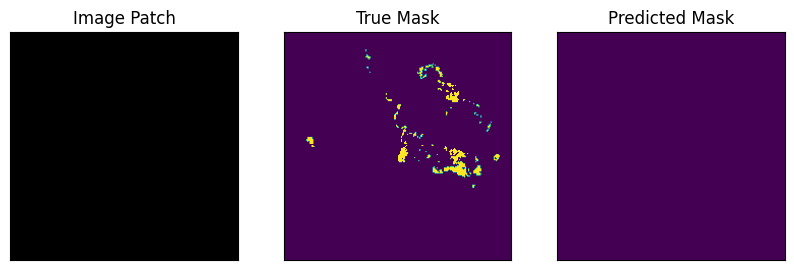

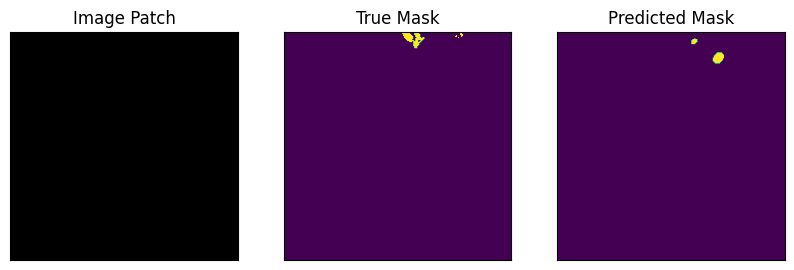

In [ ]:
preds = tuned_model_UNW.predict(x_test)

from sklearn import metrics

accuracy = metrics.accuracy_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))
precision = metrics.precision_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))
recall = metrics.recall_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))
IoU = metrics.jaccard_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))

print("Accuracy ", accuracy)
print("Precison ", precision)
print("Recall ", recall)
print("IoU", IoU)


for i in range(len(x_test[0:10])):

  true_img = x_test[i]
  mask = y_test[i]
  prediction_image = np.rint(preds[i])



  fig, (ax, m_ax, p_ax) = plt.subplots(ncols = 3)
  ax.imshow(true_img*3.5/255)
  ax.set_title('Image Patch')
  ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  ax.tick_params(axis = 'y' , left = False, labelleft = False)


  m_ax.imshow(mask)
  m_ax.set_title('True Mask')
  m_ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  m_ax.tick_params(axis = 'y' , left = False, labelleft = False)

  p_ax.imshow(prediction_image)
  p_ax.set_title('Predicted Mask')
  p_ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  p_ax.tick_params(axis = 'y' , left = False, labelleft = False)

TRANSFER LEARNING
---

In [ ]:
from bayes_opt import BayesianOptimization

# Import the required loss functions

# Define the objective function
def objective(learning_rate, dropout_rate):
    # Build the model with the current hyperparameters
    tf.keras.backend.clear_session()

    model = build_xception_unet((229,229,3), dropout_rate = dropout_rate, weights = 'imagenet', frozen_base = True)


    datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate = learning_rate), loss=dice_loss,
                  metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

    history = model.fit(datagen.flow(x_train, y_train, batch_size=16),
                        validation_data=(x_val, y_val), epochs=100, verbose=0)

    p = history.history['val_precision'][-1]
    r = history.history['val_recall'][-1]

    f1 = 2*(p*r)/(p+r)

    # Return the validation accuracy as the objective value to maximize
    return f1

# Define the parameter space
pbounds = {'learning_rate': (1e-5, 1e-2),
           'dropout_rate': (0, 0.5)
           }

# Create the optimizer
optimizer = BayesianOptimization(f=objective, pbounds=pbounds)

# Perform the optimization
optimizer.maximize(init_points=5, n_iter=10)

# Get the best set of hyperparameters
best_params = optimizer.max['params']
print(best_params)



|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
| 1         | 0.09229   | 0.03967   | 0.002753  |
| 2         | 0.04279   | 0.2269    | 0.00306   |
| 3         | 0.05749   | 0.3601    | 0.003004  |
| 4         | 0.1027    | 0.1215    | 0.008182  |
| 5         | 0.08205   | 0.4449    | 0.003162  |
| 6         | 0.0533    | 0.3294    | 0.00773   |
| 7         | 0.1458    | 0.08699   | 1e-05     |
| 8         | 0.1038    | 0.05692   | 0.0001498 |
| 9         | 0.0642    | 0.1214    | 0.008104  |
| 10        | 0.06594   | 0.1215    | 0.008087  |
| 11        | 0.05486   | 0.06561   | 0.008749  |
| 12        | 0.09197   | 0.3993    | 0.007074  |
| 13        | 0.04488   | 0.1092    | 0.008071  |
| 14        | 0.09406   | 0.03951   | 0.00276   |
| 15        | 0.08226   | 0.1968    | 0.0002756 |
{'dropout_rate': 0.08698527723621716, 'learning_rate': 1e-05}


In [ ]:
tf.keras.backend.clear_session()

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tuned_model = build_xception_unet((229,229,3), dropout_rate = 0.08698527723621716, weights = 'imagenet', frozen_base = True)
tuned_model.compile( optimizer =keras.optimizers.Adam(0.00001)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )

tuned_history = tuned_model.fit(datagen.flow(x_train, y_train, batch_size=16),
                      validation_data=(x_val, y_val), epochs=500)

tuned_model.save("xceptionUNET_TL_tuned_500e_bs16.h5")

np.save('history_xceptionUNET_TL_tuned_500e_bs16.npy',tuned_history.history)

Epoch 1/500
22/22 [==============================] - 8s 235ms/step - loss: 0.9794 - accuracy: 0.3884 - recall: 0.6021 - precision: 0.0103 - val_loss: 0.9791 - val_accuracy: 0.0820 - val_recall: 0.8890 - val_precision: 0.0102
Epoch 2/500
22/22 [==============================] - 4s 174ms/step - loss: 0.9793 - accuracy: 0.4085 - recall: 0.6096 - precision: 0.0108 - val_loss: 0.9791 - val_accuracy: 0.0496 - val_recall: 0.9523 - val_precision: 0.0106
Epoch 3/500
22/22 [==============================] - 4s 174ms/step - loss: 0.9791 - accuracy: 0.4357 - recall: 0.6197 - precision: 0.0115 - val_loss: 0.9790 - val_accuracy: 0.0957 - val_recall: 0.9342 - val_precision: 0.0109
Epoch 4/500
22/22 [==============================] - 4s 173ms/step - loss: 0.9791 - accuracy: 0.4691 - recall: 0.5960 - precision: 0.0118 - val_loss: 0.9790 - val_accuracy: 0.1865 - val_recall: 0.8700 - val_precision: 0.0113
Epoch 5/500
22/22 [==============================] - 4s 174ms/step - loss: 0.9788 - accuracy: 0.5042

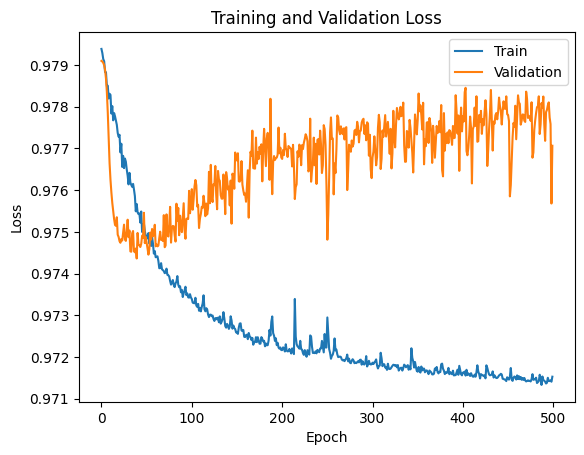

In [ ]:
## Assess at which point the model becomes overfit 

xUNET_TL_hist = np.load("history_xceptionUNET_TL_tuned_500e_bs16.npy", allow_pickle = True).item()

# xDL_NW_hist['loss']


plt.plot(xUNET_TL_hist['loss'], label='Train')
plt.plot(xUNET_TL_hist['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
tf.keras.backend.clear_session()

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tuned_model_UTL = build_xception_unet((229,229,3), dropout_rate = 0.08698527723621716, weights = 'imagenet', frozen_base = True)
tuned_model_UTL.compile( optimizer =keras.optimizers.Adam(0.00001)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )

tuned_history = tuned_model_UTL.fit(datagen.flow(x_train, y_train, batch_size=16),
                      validation_data=(x_val, y_val), epochs=50)


Epoch 1/50
22/22 [==============================] - 9s 236ms/step - loss: 0.9794 - accuracy: 0.5117 - recall: 0.4870 - precision: 0.0105 - val_loss: 0.9791 - val_accuracy: 0.2734 - val_recall: 0.7232 - val_precision: 0.0105
Epoch 2/50
22/22 [==============================] - 4s 174ms/step - loss: 0.9792 - accuracy: 0.5311 - recall: 0.5017 - precision: 0.0112 - val_loss: 0.9791 - val_accuracy: 0.1850 - val_recall: 0.8357 - val_precision: 0.0108
Epoch 3/50
22/22 [==============================] - 4s 174ms/step - loss: 0.9791 - accuracy: 0.5497 - recall: 0.5271 - precision: 0.0123 - val_loss: 0.9790 - val_accuracy: 0.3021 - val_recall: 0.7601 - val_precision: 0.0115
Epoch 4/50
22/22 [==============================] - 4s 175ms/step - loss: 0.9788 - accuracy: 0.5725 - recall: 0.5707 - precision: 0.0140 - val_loss: 0.9789 - val_accuracy: 0.6250 - val_recall: 0.5561 - val_precision: 0.0157
Epoch 5/50
22/22 [==============================] - 4s 174ms/step - loss: 0.9786 - accuracy: 0.5938 - re

In [ ]:
tuned_model_UTL.summary()

In [ ]:
tuned_model_UTL.trainable = True
tuned_model_UTL.summary()


Model: "Xception_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 229, 229, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 114, 114, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 114, 114, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                    

In [ ]:
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tuned_model_UTL.compile( optimizer =keras.optimizers.Adam(0.00001)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )

tuned_history_UTL_2 = tuned_model_UTL.fit(datagen.flow(x_train, y_train, batch_size=16),
                      validation_data=(x_val, y_val), epochs=100)

Epoch 1/100
22/22 [==============================] - 12s 311ms/step - loss: 0.9770 - accuracy: 0.8063 - recall_1: 0.5020 - precision_1: 0.0272 - val_loss: 0.9756 - val_accuracy: 0.5533 - val_recall_1: 0.9338 - val_precision_1: 0.0218
Epoch 2/100
22/22 [==============================] - 5s 237ms/step - loss: 0.9769 - accuracy: 0.8011 - recall_1: 0.5262 - precision_1: 0.0277 - val_loss: 0.9744 - val_accuracy: 0.8538 - val_recall_1: 0.7225 - val_precision_1: 0.0509
Epoch 3/100
22/22 [==============================] - 5s 238ms/step - loss: 0.9767 - accuracy: 0.7937 - recall_1: 0.5584 - precision_1: 0.0283 - val_loss: 0.9745 - val_accuracy: 0.8185 - val_recall_1: 0.7579 - val_precision_1: 0.0431
Epoch 4/100
22/22 [==============================] - 5s 238ms/step - loss: 0.9765 - accuracy: 0.7925 - recall_1: 0.5775 - precision_1: 0.0290 - val_loss: 0.9744 - val_accuracy: 0.7992 - val_recall_1: 0.7953 - val_precision_1: 0.0409
Epoch 5/100
22/22 [==============================] - 5s 237ms/step 

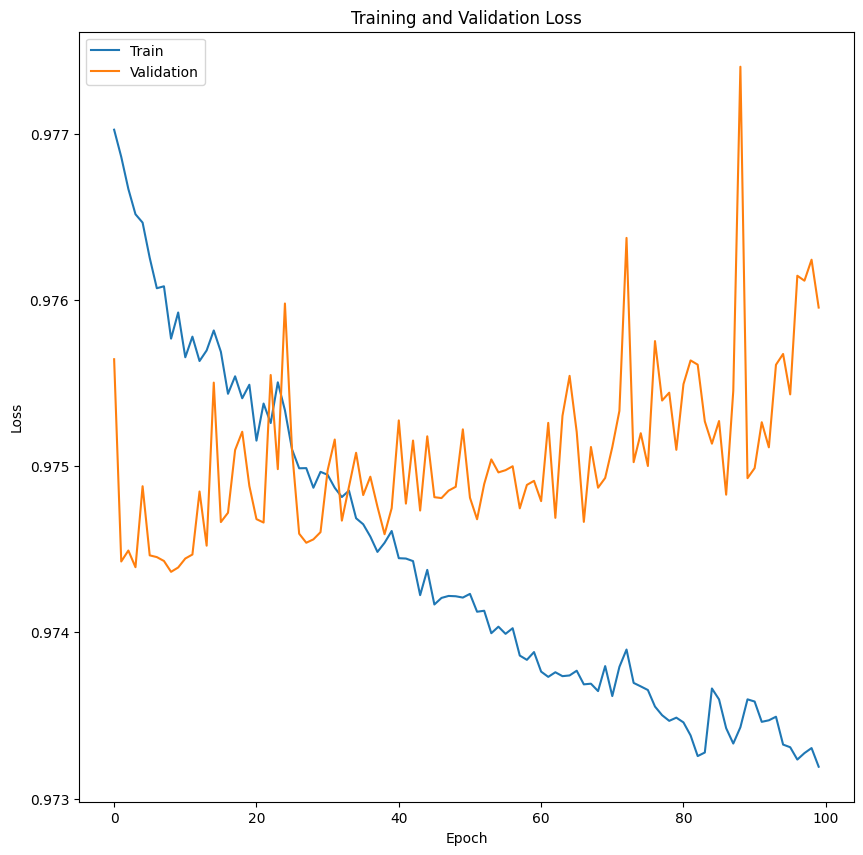

In [ ]:
## Assess at which point the model becomes overfit 




plt.plot(tuned_history_UTL_2.history['loss'], label='Train')
plt.plot(tuned_history_UTL_2.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Looks like unfreezing the model and retraining did not yield any benefits. Thus we train our final model below without fine tuning

In [ ]:
tf.keras.backend.clear_session()

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
tuned_model_UTL = build_xception_unet((229,229,3), dropout_rate = 0.08698527723621716, weights = 'imagenet', frozen_base = True)
tuned_model_UTL.compile( optimizer =keras.optimizers.Adam(0.00001)
              ,loss= dice_loss
              ,metrics=[ 'accuracy' , tf.keras.metrics.Recall() , tf.keras.metrics.Precision()]
              )


tuned_history = tuned_model_UTL.fit(datagen.flow(final_x_train, final_y_train, batch_size=16),epochs=50)

Epoch 1/50
28/28 [==============================] - 8s 161ms/step - loss: 0.9792 - accuracy: 0.5107 - recall: 0.5067 - precision: 0.0109
Epoch 2/50
28/28 [==============================] - 4s 158ms/step - loss: 0.9791 - accuracy: 0.5297 - recall: 0.5145 - precision: 0.0115
Epoch 3/50
28/28 [==============================] - 4s 159ms/step - loss: 0.9790 - accuracy: 0.5540 - recall: 0.5095 - precision: 0.0120
Epoch 4/50
28/28 [==============================] - 4s 159ms/step - loss: 0.9788 - accuracy: 0.5874 - recall: 0.5277 - precision: 0.0135
Epoch 5/50
28/28 [==============================] - 4s 159ms/step - loss: 0.9786 - accuracy: 0.6227 - recall: 0.5194 - precision: 0.0145
Epoch 6/50
28/28 [==============================] - 4s 159ms/step - loss: 0.9785 - accuracy: 0.6477 - recall: 0.5117 - precision: 0.0153
Epoch 7/50
28/28 [==============================] - 4s 158ms/step - loss: 0.9781 - accuracy: 0.6588 - recall: 0.5535 - precision: 0.0170
Epoch 8/50
28/28 [=======================

In [ ]:
tuned_model_UTL.save("xceptionUNET_TL_best.h5")

np.save('history_xceptionUNET_TL_best.npy',tuned_history.history)

2/2 [==============================] - 0s 110ms/step


Accuracy  0.8736160714285715
Precison  0.6765513225752786
Recall  0.04996590511177595
IoU 0.04880017039710325
F1 0.09305904360909138


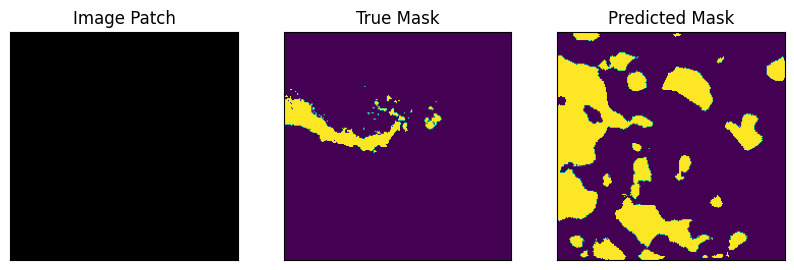

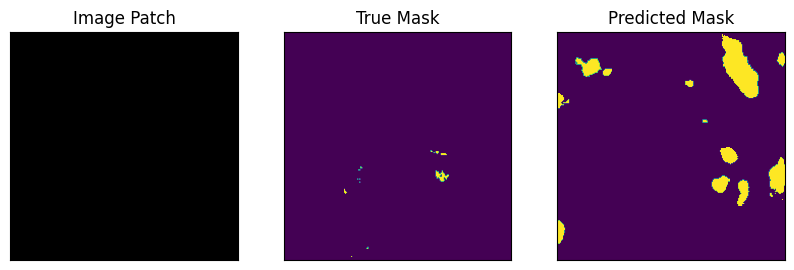

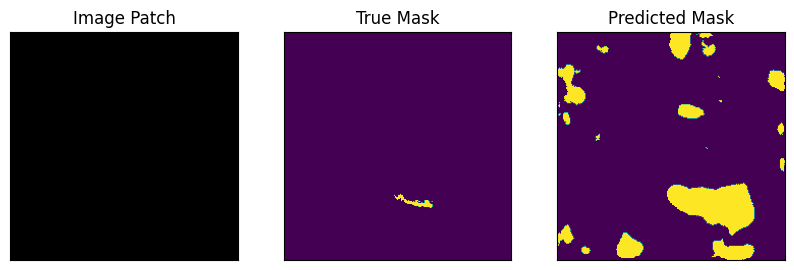

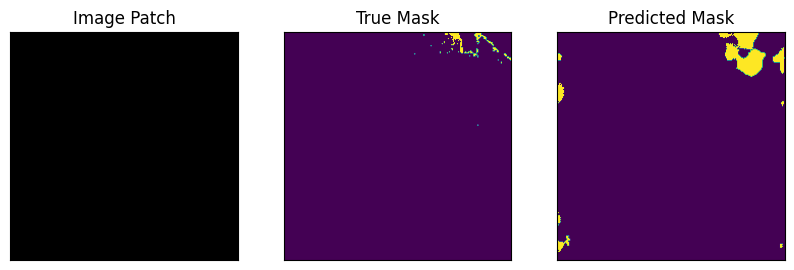

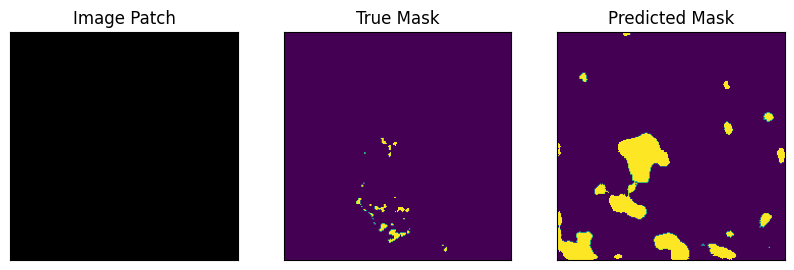

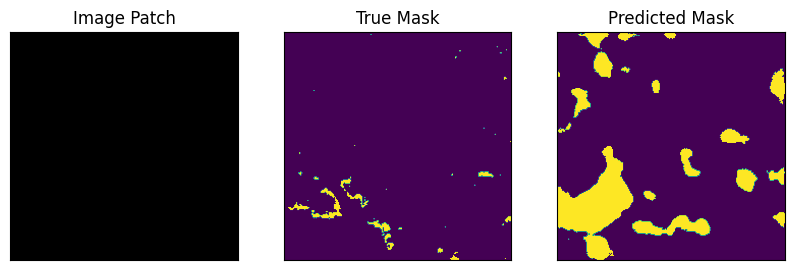

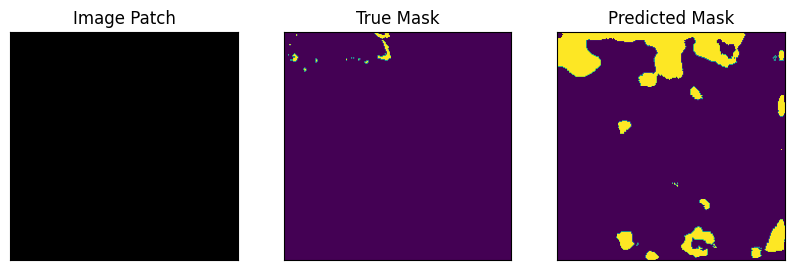

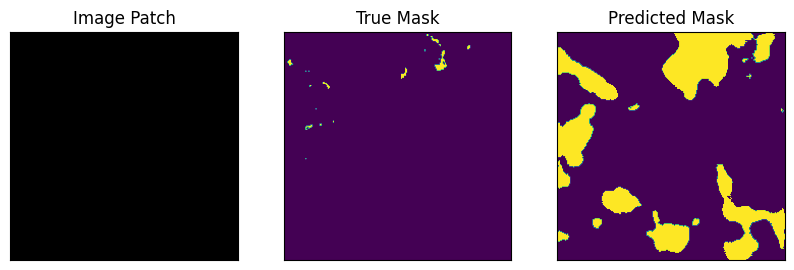

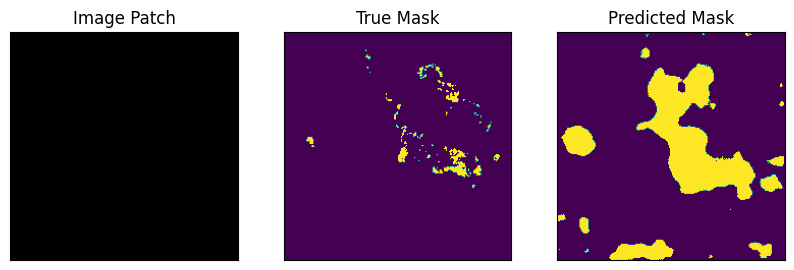

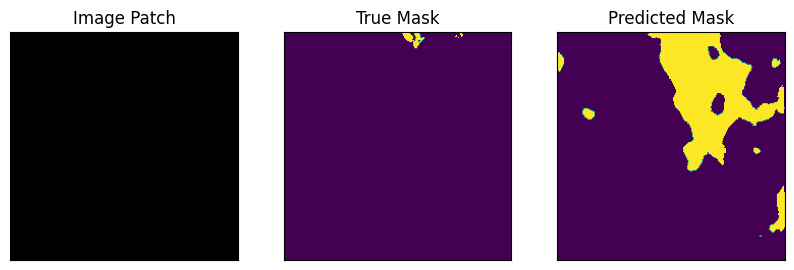

In [ ]:
preds = tuned_model_UTL.predict(x_test)

from sklearn import metrics


accuracy = metrics.accuracy_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))
precision = metrics.precision_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))
recall = metrics.recall_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))
IoU = metrics.jaccard_score(np.rint(preds.reshape(-1)), y_test.reshape(-1))

print("Accuracy ", accuracy)
print("Precison ", precision)
print("Recall ", recall)
print("IoU", IoU)
print("F1", 2*(precision*recall)/(precision+recall))

for i in range(len(x_test[0:10])):

  true_img = x_test[i]
  mask = y_test[i]
  prediction_image = np.rint(preds[i])

  fig, (ax, m_ax, p_ax) = plt.subplots(ncols = 3)
  ax.imshow(true_img*3.5/255)
  ax.set_title('Image Patch')
  ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  ax.tick_params(axis = 'y' , left = False, labelleft = False)


  m_ax.imshow(mask)
  m_ax.set_title('True Mask')
  m_ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  m_ax.tick_params(axis = 'y' , left = False, labelleft = False)

  p_ax.imshow(prediction_image)
  p_ax.set_title('Predicted Mask')
  p_ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  p_ax.tick_params(axis = 'y' , left = False, labelleft = False)


Get FLOPS
---


In [ ]:
!pip install keras-flops


In [ ]:
from keras_flops import get_flops


In [ ]:
tf.keras.backend.clear_session()

tuned_model = DeeplabV3Plus(229,1)


flops = get_flops(tuned_model, batch_size=16)

print(f"FLOPS: {flops / 10 ** 9:.03} G")

FLOPS: 2.67e+02 G


In [ ]:
tf.keras.backend.clear_session()

tuned_model = build_xception_unet((229,229,3))


flops = get_flops(tuned_model, batch_size=16)

print(f"FLOPS: {flops / 10 ** 9:.03} G")

FLOPS: 8.63e+02 G


In [ ]:
os.chdir('drive/MyDrive/COMP90055/code/all_data')


In [ ]:
tf.keras.backend.clear_session()

tuned_model = DeeplabV3Plus(229,1)

tf.keras.utils.plot_model (tuned_model, to_file = 'xcept_DL_PLOT.png', show_shapes = True, show_layer_names = True)

In [ ]:
tf.keras.backend.clear_session()

tuned_model = build_xception_unet((229,229,3))

tf.keras.utils.plot_model (tuned_model, to_file = 'xcept_UNET_PLOT.png', show_shapes = True, show_layer_names = True)